# O-mode Reflectometry simulator

Getting a simulated profile, extract the simulated signal from said profile and reconstruct the profile.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps
import sys
sys.path.append('../reflib/')
from reflib import *
from scipy import signal

## Simulating a typical AUG L-mode density profile

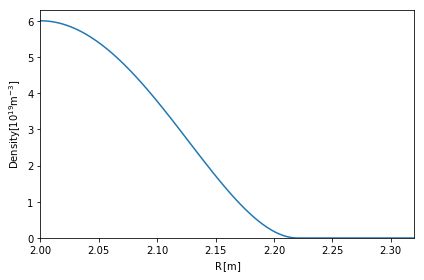

In [5]:
R0 = 2.22
Rant = 2.32
Rmid = 2.0
radius, dens = SimulDensPerf(Rmid=Rmid, R0=R0, Rant=Rant, m=2, n=2)
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.plot(radius, dens*1e-19)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()
plt.show()

In [6]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

(0, 6.3)

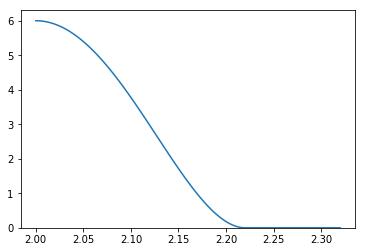

In [7]:
hollowdens = dens#-gaussian(radius, 2.13, 0.01)*1e19
plt.plot(radius, hollowdens*1e-19)
plt.ylim(bottom=0)

## Declaring a frequency sweep

In [15]:
fstart = 18e9
fstop = 60e9

In [16]:
dstart = f2n(fstart)
dstop = f2n(fstop)

In [17]:
if(dens[0]<=max(dens)):
    hollowdens=np.flip(hollowdens, axis=0)

In [18]:
monodens = np.maximum.accumulate(hollowdens)
monodens[monodens<=0]=0
if(dens[0]<=max(dens)):
    hollowdens=np.flip(hollowdens, axis=0)
    monodens=np.flip(monodens, axis=0)
    

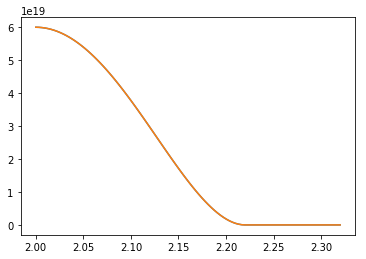

In [19]:
plt.plot(radius, hollowdens)
plt.plot(radius, monodens)

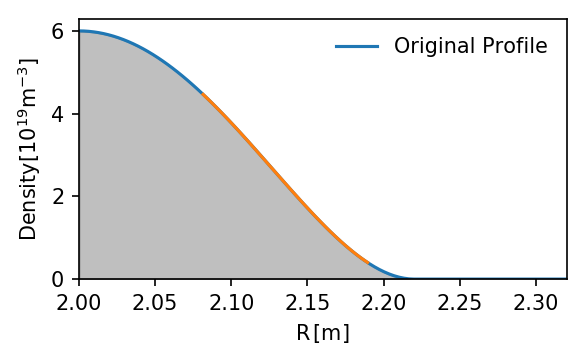

In [20]:
plt.figure(figsize=(4,2.5), dpi=150)
plt.plot(radius, hollowdens*1e-19, label='Original Profile')

densint = interp1d(monodens, radius)
probing_densities = np.linspace(dstart, dstop, 1024, endpoint=True)
radint = densint(probing_densities)
plt.plot(radint, probing_densities*1e-19)


#plt.plot(radint, densint, label='Probing Region', lw=3)
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.fill_between(radius, hollowdens*1e-19, 0.0, color='k', alpha=0.25)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig('figures/profile_probe.png', dpi=300)
plt.show()

In [21]:
fpts = 1024
fprobe = np.linspace(fstart, fstop, fpts, endpoint=True)

### Refractive index

/home/guimas/anaconda3/envs/ref/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


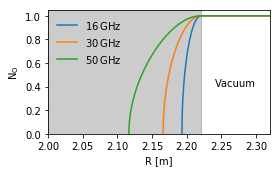

In [22]:
interpts = 8192
dens = monodens
interp_perf = interp1d(radius, dens)
interp_rad = interp1d(dens, radius)
total_phase = []

plt.figure(figsize=(4,2.5))

fps = [16, 30, 50]

for fp in fps:
    dens_probe = f2n(fp*1e9)
    r_int = np.linspace(interp_rad(dens_probe), Rant, interpts, endpoint=True)
    n_int = interp_perf(r_int)

    NO = np.sqrt(1-n_int/dens_probe)
    NO[0] = 0.0
    plt.plot(r_int, NO, label='$\mathrm{'+str(fp)+'\,GHz}$')


plt.axvspan(Rmid, R0, color='k', alpha=0.2)
plt.text(2.24, 0.4, 'Vacuum')
plt.ylabel('$\mathrm{N_{O}}$')
plt.xlabel('R [m]')
plt.legend(frameon=False, loc='upper left')
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()
plt.savefig('figures/omode_refindex.png', dpi=300)
plt.show()

### Total phase shift

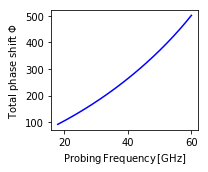

In [23]:
total_phase = []
#Avoid numerical errors due to the sqrt
epsi = 1e-15

#Do a numeric aproach 
for f in fprobe:
    dens_probe = f2n(f)
    r_int = np.linspace(interp_rad(dens_probe)+epsi, Rant, interpts, endpoint=True)
    n_int = interp_perf(r_int)
    #Refractive index
    NO = np.sqrt(1-n_int/dens_probe)
    NO[0] = 0.0
        
    #Refractive index
    total_phase.append( 4.0*np.pi*f/2.998e8*simps(NO, x=r_int)-np.pi/2 )
    
    
#Not interested in the error, hence the [0]
total_phase = np.array(total_phase)

plt.figure(figsize=(3,2.5))

plt.plot(fprobe*1e-9, total_phase, color='b')
plt.xlabel('$\mathrm{Probing\,Frequency\,[GHz]}$')
plt.ylabel('Total phase shift $\Phi$')
plt.tight_layout()
plt.savefig('figures/total_phase_shift.png', dpi=300)
plt.show()

### Simulated signal

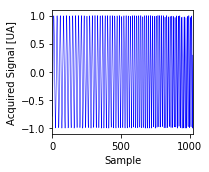

In [24]:
plt.figure(figsize=(3,2.5))
sig = np.cos(total_phase)
plt.xlabel('Sample')
plt.ylabel('Acquired Signal [UA]')
plt.plot(sig, color='blue', lw=0.5)
plt.xlim(0, fpts)
plt.tight_layout()
plt.savefig('figures/simulated_signal.png', dpi=300)
plt.show()

### Spectral analysis

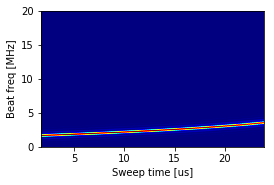

In [25]:
fsamp = 40e6
f, t, Sxx = signal.spectrogram(sig, fsamp*1e-6, nfft=2048, nperseg=136, noverlap=128)#, nperseg=32, noverlap=16)

plt.figure(figsize=(4,2.5))

plt.pcolormesh(t, f, Sxx, cmap='jet')
#plt.ylim(0, 4.0)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [MHz]')
plt.show()

### Extracting the beat frequency

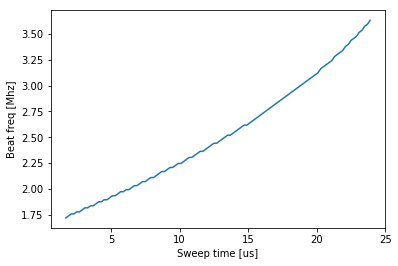

In [26]:
beat_f = f[np.argmax(Sxx, axis=0)]

plt.plot(t, beat_f)
#plt.ylim(0, 2.)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [Mhz]')
plt.show()

### Best-path?

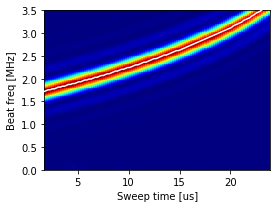

In [27]:
fsamp = 40e6
f, t, Sxx = signal.spectrogram(sig, fsamp*1e-6, nfft=2048, nperseg=136, noverlap=128)#, nperseg=32, noverlap=16)

beat_f = f[np.argmax(Sxx, axis=0)]

plt.figure(figsize=(4,3.))

plt.pcolormesh(t, f, Sxx, cmap='jet')
plt.plot(t, beat_f, zorder=10, color='w')
plt.ylim(0, 3.5)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [MHz]')
plt.tight_layout()
plt.savefig('figures/Mapping_bp.png', dpi=300)
plt.show()

In [31]:
Swp_rate = (fstop-fstart) / (1024.0/fsamp)
print(Swp_rate)

1640625000000000.0


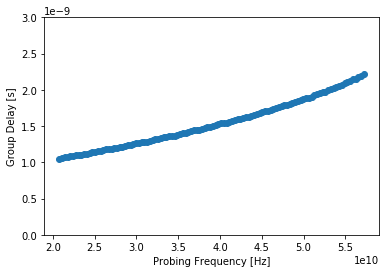

In [32]:
tau_g = beat_f*1e6 / Swp_rate
f_probsw = t*1e-6/(1024.0/fsamp)*(fstop-fstart) + fstart

plt.scatter(f_probsw, tau_g)
plt.ylim(0, 3e-9)
plt.xlabel('Probing Frequency [Hz]')
plt.ylabel('Group Delay [s]')
plt.show()

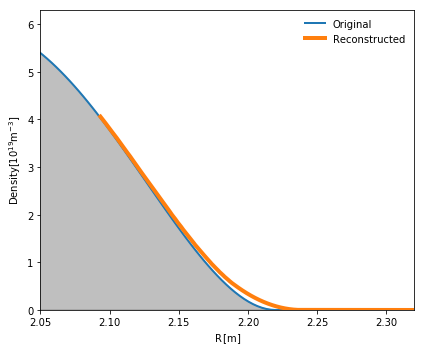

In [35]:
plt.figure(figsize=(6,5))
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.fill_between(radius, dens*1e-19, 0.0, color='k', alpha=0.25)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()

Rinit = 2.24
r, n, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-Rinit)
plt.plot(radius, dens*1e-19, label='Original', lw=2)
R_reco = Rant-r
plt.plot(R_reco, n*1e-19, label='Reconstructed', lw=4)
plt.xlim(2.05, 2.32)
plt.legend(frameon=False)
plt.tight_layout()

#plt.savefig('figures/Reconstructed_profile.png', dpi=300)
plt.show()

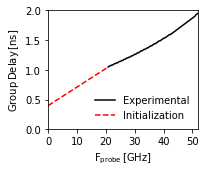

In [34]:
plt.figure(figsize=(3,2.5))

init_pts = 32
init_fpro = np.linspace(0.0, f_probsw[0], init_pts)
vac_gdel_example = (2.32-2.26)*2.0/2.998e8
init_tau = np.linspace(vac_gdel_example, tau_g[0], init_pts)

plt.plot(f_probsw*1e-9, tau_g*1e9, color='k', label='Experimental')
plt.plot(init_fpro*1e-9, init_tau*1e9, color='r', ls='--', label='Initialization')

plt.legend(frameon=False)
plt.ylim(0.0, 2.)
plt.xlim(0, 52)
plt.xlabel('$\mathrm{F_{probe}\,[GHz]}$')
plt.ylabel('$\mathrm{Group\,Delay\,[ns]}$')
plt.xticks([0,10,20,30,40,50])
plt.tight_layout()
plt.savefig('figures/group_delay_final.png', dpi=300)
plt.show()

### Compute the differences between method and original data

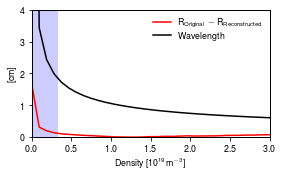

In [52]:
mindens = 0.001e19
maxdens = max(n)
densdiff = np.linspace(mindens, maxdens, endpoint=True)

interp_orig_data = interp1d(dens, radius)
interp_reco_data = interp1d(n, R_reco)
plt.figure(figsize=(4,2.5))
plt.axvspan(0,f2n(16e9)*1e-19, color='b', alpha=0.2)
plt.plot(densdiff*1e-19, np.abs(interp_orig_data(densdiff)-interp_reco_data(densdiff))*1e2,
         label='$\mathrm{R_{Original}-R_{Reconstructed}}$')
plt.plot(densdiff*1e-19, 2.998e8/(n2f(densdiff))*1e2, color='k', label='Wavelength')
plt.xlim(0,3)
plt.ylabel('$\mathrm{[cm]}$')
plt.xlabel('$\mathrm{Density\,[10^{19}m^{-3}]}$')
plt.legend(frameon=False)
plt.ylim(0,4)
plt.tight_layout()
plt.savefig('figures/uncertainty.png', dpi=300)

#### Excellent initialization

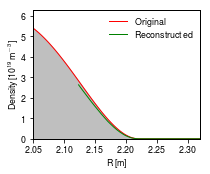

In [23]:
plt.figure(figsize=(3,2.5))
plt.xlabel('$\mathrm{R\,[m]}$')
plt.ylabel('$\mathrm{Density [10^{19}m^{-3}]}$')
plt.fill_between(radius, dens*1e-19, 0.0, color='k', alpha=0.25)
plt.ylim(bottom=0)
plt.xlim(Rmid, Rant)
plt.tight_layout()

Rinit = 2.22
r, n, fpro, gdel = CalcInvPerfO(f_probsw, tau_g, vacd=Rant-Rinit)
plt.plot(radius, dens*1e-19, label='Original', lw=1)
R_reco = Rant-r
plt.plot(R_reco, n*1e-19, label='Reconstructed', lw=1)
plt.xlim(2.05, 2.32)
plt.legend(frameon=False)
plt.tight_layout()

plt.savefig('figures/excellent_reconstructed_profile.png', dpi=300)
plt.show()

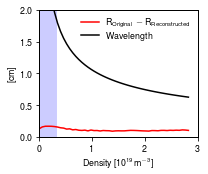

In [20]:
mindens = 0.001e19
maxdens = max(n)
densdiff = np.linspace(mindens, maxdens, endpoint=True)

interp_orig_data = interp1d(dens, radius)
interp_reco_data = interp1d(n, R_reco)

plt.figure(figsize=(3,2.5))
plt.axvspan(0,f2n(16e9)*1e-19, color='b', alpha=0.2)
plt.plot(densdiff*1e-19, np.abs(interp_orig_data(densdiff)-interp_reco_data(densdiff))*1e2,
         label='$\mathrm{R_{Original}-R_{Reconstructed}}$')
plt.plot(densdiff*1e-19, 2.998e8/(n2f(densdiff))*1e2, color='k', label='Wavelength')
plt.xlim(0,3)
plt.ylabel('$\mathrm{[cm]}$')
plt.xlabel('$\mathrm{Density\,[10^{19}m^{-3}]}$')
plt.legend(frameon=False)
plt.ylim(0,2)
plt.tight_layout()
plt.savefig('figures/excellent_uncertainty.png', dpi=300)